In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox
from src.augmentations import RandomContrast

In [3]:
IMG_PATH = "./data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [4]:
target_size = 224

seed = 42
device = "cuda"

In [5]:
B = 2 # Number of bounding boxes per grid item
C = 20 # Number of classes
S = 7 # Grid size

In [6]:
data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

In [7]:
data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

In [8]:
example = data_list[0]
example

ImageEntry(filename='2009_004619.jpg', width=500, height=333, classnames=['person', 'person', 'train'], class_id=[14, 14, 18], bounding_boxes=[[80.0, 158.0, 26, 120], [167.0, 83.5, 26, 81], [112.0, 93.0, 224, 186]])

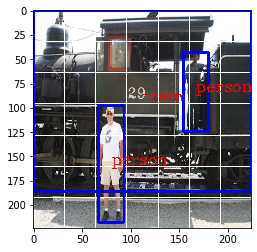

In [9]:
img_str = IMG_PATH + example[0]
img = display.read_img(img_str, target_size)

img = display.draw_grid(img, int(np.ceil(target_size / S)))
img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [10]:
def create_yolo_target(data_list, S, B, C, target_size):    
    grid_size = target_size / S

    y_list = []

    for data in data_list: 
        # For one grid element: [pc, c1, ..., cN, b1x, b1y, w1, h1, b2x, b2y, w2, h2]
        y = np.zeros((1, S, S, 5*B + C))

        classes = data.class_id
        boxes = data.bounding_boxes

        for i in range(len(boxes)):
            box = boxes[i]

            center_width = box[0]
            center_height = box[1]

            width_index = int(np.floor((center_width / target_size) * S))
            height_index = int(np.floor((center_height / target_size) * S))

            class_index = classes[i]

            # Normalize width and height by the enitre image size
            w = box[2] / target_size
            h = box[3] / target_size

            # Normalize bx and by according to the current grid position
            cx = (center_width - ((width_index / S) * target_size)) / grid_size
            cy = (center_height - ((height_index / S) * target_size)) / grid_size

            y[:, width_index, height_index, class_index] = 1.0

            # Hardcoded for B=2
            if y[:, width_index, height_index, 20] == 0.0:
                y[:, width_index, height_index, 20] = 1.0
                y[:, width_index, height_index, 21] = cx
                y[:, width_index, height_index, 22] = cy
                y[:, width_index, height_index, 23] = w
                y[:, width_index, height_index, 24] = h
            else:
                y[:, width_index, height_index, 25] = 1.0
                y[:, width_index, height_index, 26] = cx
                y[:, width_index, height_index, 27] = cy
                y[:, width_index, height_index, 28] = w
                y[:, width_index, height_index, 29] = h

        y_list.append(y)
    y = np.concatenate(y_list, axis=0)

    return y

In [11]:
def create_lambda_indicator(y, lambda_coord=5.0, lambda_noobj=0.5):
    lambda_indicator = (y > 0.0).astype(float)

    lambda_indicator[:, :, :, 0:20][(lambda_indicator[:, :, :, 20] != 0.0) | 
                                    (lambda_indicator[:, :, :, 25] != 0.0)] = 1.0

    lambda_indicator[:, :, :, 20][lambda_indicator[:, :, :, 20] == 0.0] = lambda_noobj
    lambda_indicator[:, :, :, 21] = lambda_indicator[:, :, :, 21]*lambda_coord
    lambda_indicator[:, :, :, 22] = lambda_indicator[:, :, :, 22]*lambda_coord
    lambda_indicator[:, :, :, 23] = lambda_indicator[:, :, :, 23]*lambda_coord
    lambda_indicator[:, :, :, 24] = lambda_indicator[:, :, :, 24]*lambda_coord

    lambda_indicator[:, :, :, 25][lambda_indicator[:, :, :, 25] == 0.0] = lambda_noobj
    lambda_indicator[:, :, :, 26] = lambda_indicator[:, :, :, 26]*lambda_coord
    lambda_indicator[:, :, :, 27] = lambda_indicator[:, :, :, 27]*lambda_coord
    lambda_indicator[:, :, :, 28] = lambda_indicator[:, :, :, 28]*lambda_coord
    lambda_indicator[:, :, :, 29] = lambda_indicator[:, :, :, 29]*lambda_coord

    return lambda_indicator

def loss(y, y_hat, indicator):
    y[:,:,:,23] = torch.sqrt(y[:,:,:,23])
    y[:,:,:,24] = torch.sqrt(y[:,:,:,24])
    y[:,:,:,28] = torch.sqrt(y[:,:,:,28])
    y[:,:,:,29] = torch.sqrt(y[:,:,:,29])

    y_hat[:,:,:,23] = torch.sqrt(y_hat[:,:,:,23])
    y_hat[:,:,:,24] = torch.sqrt(y_hat[:,:,:,24])
    y_hat[:,:,:,28] = torch.sqrt(y_hat[:,:,:,28])
    y_hat[:,:,:,29] = torch.sqrt(y_hat[:,:,:,29])

    return torch.sum(indicator * ((y - y_hat)*(y - y_hat)))

In [12]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path
        self.data_list = data_list_

        y = create_yolo_target(self.data_list, S, B, C, target_size_)
        lambda_indicator = create_lambda_indicator(y)

        self.y = torch.from_numpy(y).float()
        self.lambda_indicator = torch.from_numpy(lambda_indicator).float()

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
        
        self.train_mode = train_mode
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_str = self.path + self.data_list[idx].filename

        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        if self.train_mode:
            img = self.contrast(img)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std

        img = torch.from_numpy(img).float().to(device)

        temp_y = self.y[idx,:].to(device)
        temp_lambda = self.lambda_indicator[idx, :, :, :].to(device)

        return (img, temp_y, temp_lambda)

In [13]:
batch_size = 64
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset = PascalData(data_list[split_idx:])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [14]:
class Model(nn.Module):
    def __init__(self, p, n_hidden=4096):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.fc = nn.Linear(512*7*7, n_hidden)
        self.drop = nn.Dropout(p=p[1])
        self.fc_out = nn.Linear(n_hidden, S*S*(5*B + C))

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.fc_out(x)
        x = x.view(x.size(0), S, S, (5*B + C))
        x = F.relu(x)
        return x

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

In [15]:
p = [0.2, 0.5]

model = Model(p)
model = model.to(device)
model.change_freezing(False)

In [16]:
n_epochs = 20
lr = 5e-5
wd = 1e-3

In [17]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [18]:
torch.manual_seed(seed)
random.seed(seed)
for epoch in range(n_epochs+1):
    train_loss = 0.0
    model.train()
    for _, (x_i, y_i, indicator_i) in enumerate(train_loader):
        model.zero_grad()
        y_hat = model(x_i)
        batch_loss = loss(y_i, y_hat, indicator_i)

        batch_loss.backward()
        optimizer.step()

        batch_loss = batch_loss / len(x_i)
        train_loss += batch_loss.detach().cpu().numpy()

    train_loss = np.round(train_loss / len(train_loader), 6)

    val_loss = 0.0
    model.eval()
    for _, (x_i, y_i, indicator_i) in enumerate(val_loader):
        y_hat = model(x_i)
        batch_loss = loss(y_i, y_hat, indicator_i)

        batch_loss = batch_loss / len(x_i)
        val_loss += batch_loss.detach().cpu().numpy()

    val_loss = np.round(val_loss / len(val_loader), 6)

    if epoch % 5 == 0:
        print(f"----- Epoch {epoch} -----")
        print(f"Train loss: {train_loss}")
        print(f"Val loss: {val_loss}")

----- Epoch 0 -----
Train loss: 12.593959
Val loss: 7.480317
----- Epoch 5 -----
Train loss: 6.40885
Val loss: 6.1535
----- Epoch 10 -----
Train loss: 5.769649
Val loss: 5.624554
----- Epoch 15 -----
Train loss: 5.398372
Val loss: 5.787839
----- Epoch 20 -----
Train loss: 5.102071
Val loss: 5.542155


In [19]:
def invert_transformation(y_hat, target_size, S, B):
    # Invert the transform used in YOLO (v1)
    grid_size = target_size / S

    output_bb = []
    for i in range(S):
        for j in range(S):
            for b in range(B):
                pc = y_hat[:, i, j, 20 + 5*b]
                pred_class_id = np.argmax(y_hat[:, i, j, 0:20][0,:])

                cx = (i + y_hat[:, i, j, 21 + 5*b])*grid_size
                cy = (j + y_hat[:, i, j, 22 + 5*b])*grid_size 
                box_width = y_hat[:, i, j, 23 + 5*b]*target_size
                box_height = y_hat[:, i, j, 24 + 5*b]*target_size

                output_bb.append(PredBoundingBox(probability=pc[0],
                                                 class_id=pred_class_id,
                                                 classname=id_cat[pred_class_id],
                                                 bounding_box=[cx[0], 
                                                               cy[0], 
                                                               box_width[0], 
                                                               box_height[0]
                                                              ]
                                                ))
    return output_bb

In [20]:
i = 1
(x_i, _, _) = val_dataset[i]
img_file = val_dataset.data_list[i].filename

In [21]:
model.eval()
y_hat = model(x_i.unsqueeze(0))
y_hat = y_hat.detach().cpu().numpy()

In [22]:
output_bb = invert_transformation(y_hat, target_size, S, B)

In [23]:
pc_threshold = 0.3
output_bb = filter(lambda x: x.probability > pc_threshold, output_bb)
output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

In [24]:
filtered_bb = non_max_suppression(output_bb)

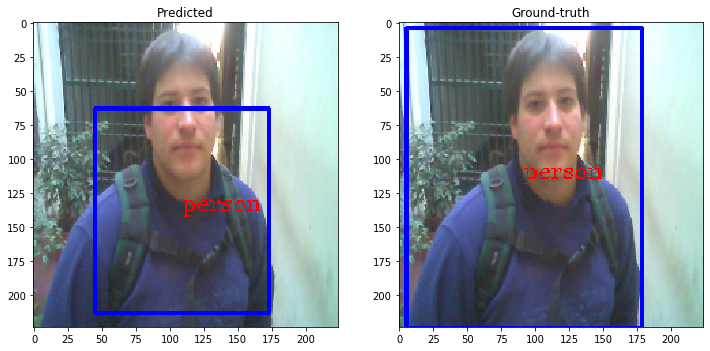

In [25]:
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()